# imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Configuration class

In [3]:
class Config():
    training_dir = "./data/images/training/"
    testing_dir = "./data/images/testing/"
    train_batch_size = 64
    train_number_epochs = 100

# Custom Dataset

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

# Using Image folder dataset

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

# Data preprocessing

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform= transforms.Compose([
        transforms.RandomResizedCrop(size=227, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])
                                       ,should_invert=False)

# Siamese network using Mobilenet architecture

In [7]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
    
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.cnn1 = nn.Sequential(
            conv_bn(  3,  32, 2), 
            conv_dw( 32,  64, 1),
            conv_dw( 64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc1 = nn.Linear(1024, 1000)

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(-1, 1024)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive loss

In [8]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Training

In [9]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [10]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [11]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0, img1 , label
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

Epoch number 0
 Current loss 3.1944360733032227

Epoch number 0
 Current loss 3.174081325531006

Epoch number 0
 Current loss 1.701921820640564

Epoch number 0
 Current loss 0.8956636190414429

Epoch number 0
 Current loss 1.1950452327728271

Epoch number 1
 Current loss 2.4917564392089844

Epoch number 1
 Current loss 1.136193037033081

Epoch number 1
 Current loss 1.1887576580047607

Epoch number 1
 Current loss 0.3170476257801056

Epoch number 1
 Current loss 0.4100229740142822

Epoch number 2
 Current loss 1.3303990364074707

Epoch number 2
 Current loss 0.8169159889221191

Epoch number 2
 Current loss 0.41358381509780884

Epoch number 2
 Current loss 0.4237070381641388

Epoch number 2
 Current loss 0.5734097361564636

Epoch number 3
 Current loss 1.2425118684768677

Epoch number 3
 Current loss 0.2902306020259857

Epoch number 3
 Current loss 0.8894815444946289

Epoch number 3
 Current loss 0.8685930371284485

Epoch number 3
 Current loss 0.9592316150665283

Epoch number 4
 Curren

# Testing

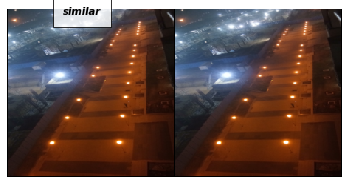

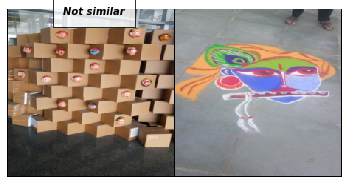

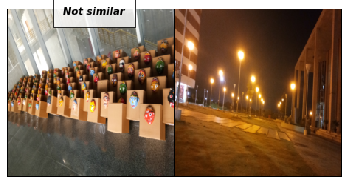

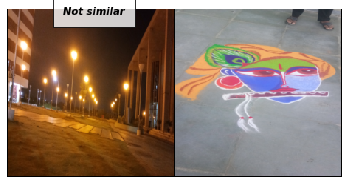

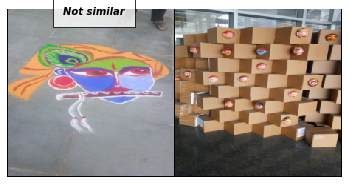

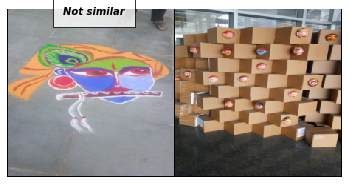

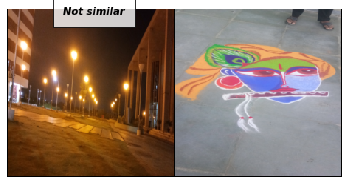

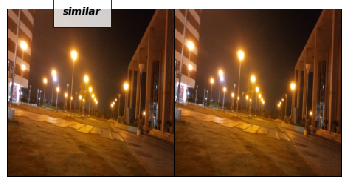

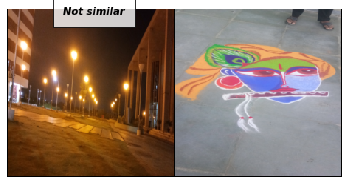

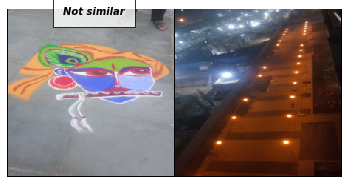

In [21]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transforms.Compose([transforms.Resize((224,224)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
#x0,_,_ = next(dataiter)

for i in range(10):
    x0,_,_ = next(dataiter)
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0),Variable(x1))
    euclidean_distance = F.pairwise_distance(output1, output2)
    if(euclidean_distance >0.1):
        imshow(torchvision.utils.make_grid(concatenated),'Not similar'.format(euclidean_distance.item()))
    else:
        imshow(torchvision.utils.make_grid(concatenated),'similar'.format(euclidean_distance.item()))


In [ ]:
: {:.2f}